In [204]:
import cv2
import numpy as np
import scipy.ndimage
from pandas import DataFrame, concat
from math import sin, cos, radians
from decimal import Decimal, ROUND_HALF_UP
import pareto_GA as ga
import practice_evaluate_sampleple as es
import seaborn as sns

In [205]:
class evaluate_sample:
    def __init__(self, **kwargs):
        self.robot_path_1 = kwargs.get('robot_map','../robot_path/small_map_path_1.png')
        self.robot_path_2 = kwargs.get('robot_map','../robot_path/small_map_path_2.png')
        self.robot_path_3 = kwargs.get('robot_map','../robot_path/small_map_path_3.png')
        self.geomap = kwargs.get('geomap','../small_map.png')#実際に検証をするマップ
        
        self.urg_range = kwargs.get('urg_pix',400)#Lidarの測定範囲
        self.urg_resolution = kwargs.get('resolution', 10)#角度分解能
        self.rotation = kwargs.get('rotaion', 180)#回転角度     
        self.deg_list = np.arange(0.0, 181.0, self.urg_resolution)#角度分解能のlist
        self.range_list = None
        self.range_list_rotation = None
        
        #LiDARの最端座標
        self.x_fin = []
        self.y_fin = []
        self.x_fin_rotation = []
        self.y_fin_rotation = []
        
        #LiDARの分解能ごとの最近傍座標
        self.x_object = []
        self.y_object = []
        self.x_object_rotation = []
        self.y_object_rotation = []
        
        #初期位置だけ灰色の地図
        self.robot_map = None
        
        #幾何地図を1,0の配列で表現
        self.object_map = None
        
        #初期位置から障害物までの距離を格納
        self.distance_map = None

        self.robot_points = None
        self.original_geomap = None
        
        self.comparison_list = None
        self.comparison_list_rotation = None
        self.delta_list = None
        self.match_count = None

        self.initial_flag = False
        self.initial_flag_rotation = False
        
        self.path_dist = None
        
    def map_from_img(self):
        #robot_pathのグリッド毎の色情報を取得(黒が0だった)
        self.img_robo_path_1 = cv2.imread(self.robot_path_1)
        self.robot_map_1 = cv2.cvtColor(self.img_robo_path_1, cv2.COLOR_BGR2GRAY)
        self.img_robo_path_2 = cv2.imread(self.robot_path_2)
        self.robot_map_2 = cv2.cvtColor(self.img_robo_path_2, cv2.COLOR_BGR2GRAY)
        self.img_robo_path_3 = cv2.imread(self.robot_path_3)
        self.robot_map_3 = cv2.cvtColor(self.img_robo_path_3, cv2.COLOR_BGR2GRAY)
        
        #robot_pathの座標を取得[(縦, 横)，・・・]
        self.robot_points_1 = np.column_stack(np.where(self.robot_map_1 < 5))
        self.robot_points_2 = np.column_stack(np.where(self.robot_map_2 < 5))
        self.robot_points_3 = np.column_stack(np.where(self.robot_map_3 < 5))  
        self.robot_points = np.concatenate([self.robot_points_1, self.robot_points_2, self.robot_points_3])
        self.path_dist = int((len(self.robot_points))/3)
        
        #幾何地図を1,0で表現(黒を1に，白を0に)
        self.img_geomap = cv2.imread(self.geomap)
        self.original_geomap = cv2.cvtColor(self.img_geomap, cv2.COLOR_BGR2GRAY)
        self.object_map = np.where(self.original_geomap < 5, 1, 0)
        print(self.object_map.sum())
        print("robot_points_length = %d, 1path_dist = %d" % (len(self.robot_points),self.path_dist))
        return len(self.robot_points)
       
    def map_init_u(self, current_num=0):
        #0が並んだ地図を用意
        self.robot_map = self.robot_map_1
        self.robot_map[:,:] = 0
        
        #robot_mapの現地点を灰色に
        self.robot_map[self.robot_points[current_num][0], self.robot_points[current_num][1]] = 155
        
        #現地点から各グリッドまでの距離を格納した配列を生成
        self.distance_map = scipy.ndimage.morphology.distance_transform_edt(self.robot_map==0)        
        
    def urg_scan(self, current_num):
        #LiDARの各照射角度での最端座標の配列
        self.x_fin[:] = []
        self.y_fin[:] = []
        
        #(x, y) = (横，縦)　に
        original_x = self.robot_points[current_num][1]
        original_y = self.robot_points[current_num][0]

        #x,y_finに各照射角度の最端座標が格納(時計回りで90°〜-90°)
        for r in self.deg_list:
            x_ = self.urg_range * cos(radians(90-r))
            y_ = self.urg_range * sin(radians(90-r))
            x_ = Decimal(str(x_)).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
            y_ = Decimal(str(y_)).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
            x  = original_x + x_
            y  = original_y - y_
            self.x_fin.append(int(x))
            self.y_fin.append(int(y))
    
    def bresenham(self, current_num):
        self.x_object = []#total_num番目の基準点におけるLiDARが当たっている物体座標が格納される
        self.y_object = []
        self.range_list = []
    
        #現地点の座標をoriginal_x, yに格納
        original_x = self.robot_points[current_num][1]
        original_y = self.robot_points[current_num][0]

        for i in range(len(self.deg_list)):
            #現地点から現照射角度の最端座標をx, yに格納
            x = self.x_fin[i]
            y = self.y_fin[i]
            delta_x = abs(x - original_x) 
            delta_y = abs(y - original_y) 
            error = 0
            write_x = original_x
            write_y = original_y
            
            x1 = y - original_y + original_x
            x2 = original_y + original_x -y
            
            step1 = True if abs(y - original_y) < abs(x - original_x) else False
            step2 = True if original_y < y else False
            
            if step1 & step2:
                for write_x in range(original_x, x+1, 1):
                    if self.object_map[write_y][write_x] == 1:
                        d = self.distance_map[write_y][write_x]
                        self.range_list.append(d)
                        self.x_object.append(write_x)
                        self.y_object.append(write_y)
                        break
                        
                    elif write_x == x and write_y == y:
                        self.range_list.append(0.0)
                        self.x_object.append(x)
                        self.y_object.append(y)
                        break
                        
                    else:
                        error += 2*delta_y - delta_x
                        if error >= 0:#右上に進む(でなければ右に進む)
                            write_y += 1
                            error -= delta_x
                            
                        else:
                            error += delta_x
                 
            elif (not step1) & step2:
                new_x, new_y = original_x, original_y 
                for new_x in range(original_x, x1+1, 1):
                    write_x = new_y + original_x - original_y
                    write_y = new_x + original_y - original_x
                    if self.object_map[write_y][write_x] == 1:
                        d = self.distance_map[write_y][write_x]
                        self.range_list.append(d)
                        self.x_object.append(write_x)
                        self.y_object.append(write_y)
                        break
                        
                    elif write_x == x and write_y == y:
                        self.range_list.append(0.0)
                        self.x_object.append(x)
                        self.y_object.append(y)
                        break
                        
                    else:
                        error += 2*delta_x - delta_y
                        if error >= 0:#右上に進む(でなければ右に進む)
                            new_y += 1
                            error -= delta_y
                        
                        else:
                            error += delta_y

            elif step1 & (not step2):
                new_y = original_y
                for write_x in range(original_x, x+1, 1):
                    write_y = 2*original_y - new_y
                    if self.object_map[write_y][write_x] == 1:
                        d = self.distance_map[write_y][write_x]
                        self.range_list.append(d)
                        self.x_object.append(write_x)
                        self.y_object.append(write_y)
                        break
                        
                    elif write_x == x and write_y == y:
                        self.range_list.append(0.0)
                        self.x_object.append(x)
                        self.y_object.append(y)
                        break
                        
                    else:
                        error += 2*delta_y - delta_x
                        if error >= 0:#右上に進む(でなければ右に進む)
                            new_y += 1
                            error -= delta_x
                            
                        else:
                            error += delta_x
                            
            else:
                new_x, new_y = original_x, original_y 
                for new_x in range(original_x, x2+1, 1):
                    write_x = new_y + original_x - original_y
                    write_y = original_y + original_x - new_x

                    if self.object_map[write_y][write_x] == 1:
                        d = self.distance_map[write_y][write_x]
                        self.range_list.append(d)
                        self.x_object.append(write_x)
                        self.y_object.append(write_y)
                        break
                        
                    elif write_x == x and write_y == y:
                        self.range_list.append(0.0)
                        self.x_object.append(x)
                        self.y_object.append(y)
                        break
                        
                    else:
                        error += 2*delta_x - delta_y
                        if error >= 0:
                            new_y += 1
                            error -= delta_y
                        
                        else:
                            error += delta_y
        
    def feature_df(self, current_num, total_num):
        
        if self.initial_flag == False:
            self.comparison_list = DataFrame(data=self.range_list, index=self.deg_list)#行でLiDARの照射角度、列で経路上の基準点を指定する、物体距離情報のデータフレーム_osanai
            self.initial_flag = True
        else:
            update_list = DataFrame(data=self.range_list, index=self.deg_list, columns=[current_num])
            self.comparison_list = concat([self.comparison_list, update_list], axis=1, sort=True)#もともとのやつと結合させる
        comparison_bool = (self.comparison_list.iloc[:-1,:total_num] > 0.0)#dがあればTrue、0ならばFalseを格納
        self.comparison_list.loc['count'] = comparison_bool.sum()#それぞれのポイントでの物体座標数　データフレームにcount行を追加
        
    def Urg_similarity(self, current_num, total_num):
        self.delta_list = self.comparison_list.copy()
        self.delta_list.drop('count', axis=0, inplace=True)#count行を削除
        for i in range(total_num):
            self.delta_list.iloc[:,i] = np.abs((self.comparison_list.iloc[:,i] - self.comparison_list[current_num]))#基準としたものとの差分　後ろの項が基準_osanai
        self.comparison_bool = (self.delta_list.iloc[:,:total_num] < 4.0)#基準との差が4？？より小さいところ(物体距離情報がマッチしているところ)_osanai
        self.comparison_bool2 = (self.comparison_list.iloc[:-1,:total_num] > 0.0)#物体距離情報があるところ(d=0ではないところ)_osanai
        self.comparison_bool3 = self.comparison_bool & self.comparison_bool2
        self.delta_list.loc['match'] = self.comparison_bool3.sum()#マッチしてる数_osanai
        print(self.delta_list)
        match_count = self.delta_list.loc['match']
        ori_count = self.comparison_list.loc['count']
        rate = np.divide(match_count, ori_count, out=np.zeros_like(match_count), where=ori_count!=0)#rate　Nzの元の類似度の配列、グラフの横一線_osanai
        #print(match_count, ori_count, rate)
        return rate

    def urg_scan_rotation(self, current_num):
        self.x_fin_rotation[:] = []#Lidarそれぞれの最端座標
        self.y_fin_rotation[:] = []
        original_x = self.robot_points[current_num][1]#u座標　基準点
        original_y = self.robot_points[current_num][0]#v座標

        for r in self.deg_list:
            x_ = self.urg_range * cos(radians(90-(r-self.rotation)))#180°回転！！_osanai
            y_ = self.urg_range * sin(radians(90-(r-self.rotation)))#180°回転！！_osanai
            x_ = Decimal(str(x_)).quantize(Decimal('0'), rounding=ROUND_HALF_UP)#四捨五入
            y_ = Decimal(str(y_)).quantize(Decimal('0'), rounding=ROUND_HALF_UP)
            x  = original_x + x_
            y  = original_y - y_
            self.x_fin_rotation.append(int(x))
            self.y_fin_rotation.append(int(y))
       
    def bresenham_rotation(self, current_num):
        self.x_object_rotation = []#total_num番目の基準点におけるLiDARが当たっている物体座標が格納される
        self.y_object_rotation = []
        self.range_list_rotation = []
        
        for i in range(len(self.deg_list)):
            original_x = self.robot_points[current_num][1]#u座標　基準点
            original_y = self.robot_points[current_num][0]#v座標

            x = self.x_fin_rotation[i]
            y = self.y_fin_rotation[i]

            step = True if abs(y - original_y) > abs(x - original_x) else False 
            #print(step)

            if step:
                original_x, original_y = original_y, original_x 
                x, y = y, x

            delta_x = abs(x - original_x) 
            delta_y = abs(y - original_y) 
            error = int(delta_x / 2) 
            write_y = original_y 

            inc = 1 if original_x < x else -1 
            y_step = 1 if original_y < y else -1 

            for write_x in range(original_x, x+inc, inc):
                if step:
                    if self.object_map[write_x][write_y] == 1:
                        d = self.distance_map[write_x][write_y]
                        self.range_list_rotation.append(d)#距離情報をlistに追加
                        self.x_object_rotation.append(write_y)
                        self.y_object_rotation.append(write_x)
                        break
                    if write_x == x and write_y == y:
                        self.range_list_rotation.append(0.0)
                        self.x_object_rotation.append(y)
                        self.y_object_rotation.append(x)
                else:
                    if self.object_map[write_y][write_x] == 1:
                        d = self.distance_map[write_y][write_x]
                        self.range_list_rotation.append(d)
                        self.x_object_rotation.append(write_x)
                        self.y_object_rotation.append(write_y)
                        break
                    if write_x == x and write_y == y:
                        self.range_list_rotation.append(0.0)
                        self.x_object_rotation.append(x)
                        self.y_object_rotation.append(y) 
                error = error - delta_y
                if error < 0:
                    write_y = write_y + y_step
                    error = error + delta_x
    
    def feature_df_rotation(self, current_num=0, total_num=0):
        if self.initial_flag_rotation == False:
            self.comparison_list_rotation = DataFrame(data=self.range_list_rotation, index=self.deg_list)
            self.initial_flag_rotation = True
        else:
            update_list = DataFrame(data=self.range_list_rotation, index=self.deg_list, columns=[current_num])
            self.comparison_list_rotation = concat([self.comparison_list_rotation, update_list], axis=1, sort=True)#もともとのやつと結合させる
        comparison_bool = (self.comparison_list_rotation.iloc[:-1,:total_num] > 0.0)
        self.comparison_list_rotation.loc['count'] = comparison_bool.sum()#それぞれのポイントでの物体座標数
    
    def Urg_similarity_rotation(self, current_num, total_num):
        self.delta_list_rotation = self.comparison_list.copy()
        self.delta_list_rotation.drop('count', axis=0, inplace=True)
        for i in range(total_num):
            self.delta_list_rotation.iloc[:,i] = np.abs((self.comparison_list.iloc[:,i] - self.comparison_list_rotation[current_num]))#基準としたものとの差分 0度と180度を比較_osanai
        self.comparison_bool_rotation = (self.delta_list_rotation.iloc[:,:total_num] < 4.0)
        #self.delta_list.loc['match'] = comparison_bool.sum() 
        self.comparison_bool2_rotation = (self.comparison_list_rotation.iloc[:-1,:total_num] > 0.0)
        self.comparison_bool3_rotation = self.comparison_bool_rotation & self.comparison_bool2_rotation
        self.delta_list_rotation.loc['match'] = self.comparison_bool3_rotation.sum()
      
        match_count_rotation = self.delta_list_rotation.loc['match']
        ori_count_rotation = self.comparison_list_rotation.loc['count']
        rate_rotation = np.divide(match_count_rotation, ori_count_rotation, out=np.zeros_like(match_count_rotation), where=ori_count_rotation!=0)
        return rate_rotation
    
    def Urg_similarity_rotation_both(self, current_num, total_num):
        self.delta_list_rotation_both = self.comparison_list_rotation.copy()
        self.delta_list_rotation_both.drop('count', axis=0, inplace=True)
        for i in range(total_num):
            self.delta_list_rotation_both.iloc[:,i] = np.abs((self.comparison_list_rotation.iloc[:,i] - self.comparison_list_rotation[current_num]))
        comparison_bool_rotation_both = (self.delta_list_rotation_both.iloc[:,:total_num] < 4.0)
        #self.delta_list.loc['match'] = comparison_bool.sum() 
        comparison_bool2_rotation_both = (self.comparison_list_rotation.iloc[:-1,:total_num] > 0.0)
        comparison_bool3_rotation_both = comparison_bool_rotation_both & comparison_bool2_rotation_both
        self.delta_list_rotation_both.loc['match'] = comparison_bool3_rotation_both.sum()
      
        match_count_rotation_both = self.delta_list_rotation_both.loc['match']
        ori_count_rotation_both = self.comparison_list_rotation.loc['count']
        rate_rotation_both = np.divide(match_count_rotation_both, ori_count_rotation_both, out=np.zeros_like(match_count_rotation_both), where=ori_count_rotation_both!=0)
        return rate_rotation_both


In [206]:
sample = evaluate_sample(urg_pix=20, geomap='../map/small_map.png')

In [207]:
count = sample.map_from_img()

93
robot_points_length = 18, 1path_dist = 6


In [208]:
for e in range(count):
    sample.map_init_u(current_num=e)
    sample.urg_scan(current_num=e)
    sample.bresenham(current_num=e)
    sample.feature_df(current_num=e,total_num=count)
    sample.urg_scan_rotation(current_num=e)
    sample.bresenham_rotation(current_num=e)
    sample.feature_df_rotation(current_num=e,total_num=count)
print(sample.distance_map)

[[101.13851887 100.44899203  99.76472322 ...  77.83315489  78.18567644
   78.54934755]
 [100.41912169  99.72462083  99.03534723 ...  76.89603371  77.25283166
   77.62087348]
 [ 99.70456359  99.00505038  98.31073187 ...  75.96051606  76.32168761
   76.69419796]
 ...
 [ 74.          73.05477397  72.11102551 ...  36.12478374  36.87817783
   37.64306045]
 [ 74.33034374  73.38937253  72.44998275 ...  36.79673899  37.53664876
   38.28837944]
 [ 74.67261881  73.73601562  72.80109889 ...  37.48332963  38.20994635
   38.94868419]]


In [211]:
resemblance = [sample.Urg_similarity(current_num=d,total_num=count) for d in range(count)]
resemblance_rotation = [sample.Urg_similarity_rotation(current_num=d,total_num=count) for d in range(count)]
resemblance_rotation_both = [sample.Urg_similarity_rotation_both(current_num=d,total_num=count) for d in range(count)]

        0          1          2          3          4          5          6   \
0.0    0.0  13.000000  13.000000  13.000000   0.000000   0.000000   0.000000   
10.0   0.0  13.152946  13.152946  13.152946   0.000000   0.000000   0.000000   
20.0   0.0   0.000000   0.000000   0.000000  13.928388  13.928388  13.928388   
30.0   0.0   0.000000   0.000000  15.264338  15.264338  15.264338  15.264338   
40.0   0.0   0.000000   0.000000  17.029386  17.029386  17.029386  17.029386   
50.0   0.0   0.000000   0.000000  19.849433  19.849433  19.849433  19.849433   
60.0   0.0   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
70.0   0.0   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
80.0   0.0   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
90.0   0.0   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
100.0  0.0   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
110.0  0.0   0.000000   0.000000   0.000

              0          1          2          3          4          5   \
0.0     0.000000  13.000000  13.000000  13.000000   0.000000   0.000000   
10.0    0.000000  13.152946  13.152946  13.152946   0.000000   0.000000   
20.0   13.928388  13.928388  13.928388  13.928388   0.000000   0.000000   
30.0   15.264338  15.264338  15.264338   0.000000   0.000000   0.000000   
40.0   17.029386  17.029386  17.029386   0.000000   0.000000   0.000000   
50.0    0.000000   0.000000   0.000000  19.849433  19.849433  19.849433   
60.0    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
70.0    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
80.0    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
90.0    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
100.0   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
110.0   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
120.0   0.000000   0.0000

              0    1          2          3          4          5          6   \
0.0    13.000000  0.0   0.000000   0.000000  13.000000  13.000000  13.000000   
10.0   13.152946  0.0   0.000000   0.000000  13.152946  13.152946  13.152946   
20.0    0.000000  0.0   0.000000   0.000000  13.928388  13.928388  13.928388   
30.0    0.000000  0.0   0.000000  15.264338  15.264338  15.264338  15.264338   
40.0    0.000000  0.0   0.000000  17.029386  17.029386  17.029386  17.029386   
50.0    0.000000  0.0   0.000000  19.849433  19.849433  19.849433  19.849433   
60.0    0.000000  0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
70.0    0.000000  0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
80.0    0.000000  0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
90.0    0.000000  0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
100.0   0.000000  0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
110.0   0.000000  0.0   0.000000   0.000

In [212]:
replace = np.array(resemblance)#縦横0度同士path1~3_osanai
replace_rotation = np.array(resemblance_rotation)#縦180度，横0度path1~3_osanai
replace_rotation_both = np.array(resemblance_rotation_both)#縦横180度同士path1~3_osanai

In [213]:
df1 = DataFrame(replace)
df1_sum = df1.sum()
df1_sum_sum = (df1_sum.sum()-len(sample.robot_points))/2#同じとこ除外(-類似度1*114)と、かぶってるとこ除外(÷２),要素数は(114*114)/2_osanai

df2 = DataFrame(replace_rotation)
df2_sum = df2.sum()
df2_sum_sum = df2_sum.sum()#要素数は114*114_osanai

df3 = DataFrame(replace_rotation_both)
df3_sum = df3.sum()
df3_sum_sum = (df3_sum.sum()-len(sample.robot_points))/2#同じとこ除外(-類似度1*114)と、かぶってるとこ除外(÷２),要素数は(114*114)/2_osanai

In [214]:
Nscore = (df1_sum_sum + df2_sum_sum + df3_sum_sum)/(len(sample.robot_points)*len(sample.robot_points)*2-len(sample.robot_points))#30*2C2(組み合わせ)_osanai
print(Nscore)

0.38792831947593853


<AxesSubplot:>

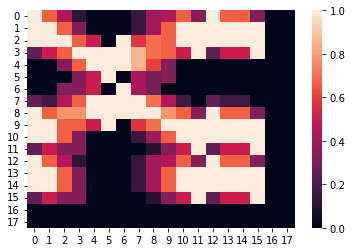

In [215]:
sns.heatmap(df1)

In [216]:
print(df1)

      0         1         2         3    4    5    6         7    8   \
0   1.00  0.666667  0.444444  0.111111  0.0  0.0  0.0  0.142857  0.4   
1   1.00  1.000000  0.666667  0.333333  0.0  0.0  0.0  0.142857  0.4   
2   1.00  1.000000  1.000000  0.666667  0.5  0.0  1.0  0.571429  0.7   
3   0.25  0.500000  0.666667  1.000000  1.0  1.0  1.0  0.857143  0.7   
4   0.00  0.000000  0.333333  0.666667  1.0  1.0  1.0  0.857143  0.6   
5   0.00  0.000000  0.000000  0.333333  0.5  1.0  0.0  0.428571  0.3   
6   0.00  0.000000  0.333333  0.333333  0.5  0.0  1.0  0.428571  0.3   
7   0.25  0.166667  0.444444  0.666667  1.0  1.0  1.0  1.000000  0.7   
8   1.00  0.666667  0.777778  0.777778  1.0  1.0  1.0  1.000000  1.0   
9   1.00  1.000000  0.666667  0.666667  0.5  1.0  0.0  0.571429  0.7   
10  1.00  1.000000  0.666667  0.333333  0.0  0.0  0.0  0.142857  0.4   
11  0.25  0.500000  0.333333  0.333333  0.0  0.0  0.0  0.000000  0.1   
12  1.00  0.666667  0.444444  0.111111  0.0  0.0  0.0  0.142857 

In [217]:
print(resemblance)

[0     1.000000
1     0.666667
2     0.444444
3     0.111111
4     0.000000
5     0.000000
6     0.000000
7     0.142857
8     0.400000
9     0.444444
10    0.666667
11    0.333333
12    1.000000
13    0.666667
14    0.666667
15    0.333333
16    0.000000
17    0.000000
dtype: float64, 0     1.000000
1     1.000000
2     0.666667
3     0.333333
4     0.000000
5     0.000000
6     0.000000
7     0.142857
8     0.400000
9     0.666667
10    1.000000
11    1.000000
12    1.000000
13    1.000000
14    1.000000
15    1.000000
16    0.000000
17    0.000000
dtype: float64, 0     1.000000
1     1.000000
2     1.000000
3     0.666667
4     0.500000
5     0.000000
6     1.000000
7     0.571429
8     0.700000
9     0.666667
10    1.000000
11    1.000000
12    1.000000
13    1.000000
14    1.000000
15    1.000000
16    0.000000
17    0.000000
dtype: float64, 0     0.250000
1     0.500000
2     0.666667
3     1.000000
4     1.000000
5     1.000000
6     1.000000
7     0.857143
8     0.700000
9     

In [218]:
print(sample.delta_list)

              0          1          2          3          4          5   \
0.0     0.000000  13.000000  13.000000  13.000000   0.000000   0.000000   
10.0    0.000000  13.152946  13.152946  13.152946   0.000000   0.000000   
20.0   13.928388  13.928388  13.928388  13.928388   0.000000   0.000000   
30.0   15.264338  15.264338  15.264338   0.000000   0.000000   0.000000   
40.0   17.029386  17.029386  17.029386   0.000000   0.000000   0.000000   
50.0   19.849433  19.849433  19.849433   0.000000   0.000000   0.000000   
60.0    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
70.0    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
80.0    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
90.0    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
100.0   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
110.0   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
120.0   0.000000   0.0000

In [219]:
sample.comparison_list

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0.0,0.000000,13.000000,13.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,13.000000,13.000000,0.000000,13.000000,13.000000,13.000000,0.0,0.0
10.0,0.000000,13.152946,13.152946,13.152946,0.000000,0.000000,0.000000,0.000000,0.000000,13.152946,13.152946,13.152946,0.000000,13.152946,13.152946,13.152946,0.0,0.0
20.0,13.928388,13.928388,13.928388,13.928388,0.000000,0.000000,0.000000,0.000000,13.928388,13.928388,13.928388,13.928388,13.928388,13.928388,13.928388,13.928388,0.0,0.0
30.0,15.264338,15.264338,15.264338,0.000000,0.000000,0.000000,0.000000,0.000000,15.264338,15.264338,15.264338,0.000000,15.264338,15.264338,15.264338,0.000000,0.0,0.0
40.0,17.029386,17.029386,17.029386,0.000000,0.000000,0.000000,0.000000,0.000000,17.029386,17.029386,17.029386,0.000000,17.029386,17.029386,17.029386,0.000000,0.0,0.0
50.0,19.849433,19.849433,19.849433,0.000000,0.000000,0.000000,0.000000,19.849433,19.849433,19.849433,19.849433,0.000000,19.849433,19.849433,19.849433,0.000000,0.0,0.0
60.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
70.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
80.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
90.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [220]:
sample.comparison_bool

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0.0,True,False,False,False,True,True,True,True,True,False,False,False,True,False,False,False,True,True
10.0,True,False,False,False,True,True,True,True,True,False,False,False,True,False,False,False,True,True
20.0,False,False,False,False,True,True,True,True,False,False,False,False,False,False,False,False,True,True
30.0,False,False,False,True,True,True,True,True,False,False,False,True,False,False,False,True,True,True
40.0,False,False,False,True,True,True,True,True,False,False,False,True,False,False,False,True,True,True
50.0,False,False,False,True,True,True,True,False,False,False,False,True,False,False,False,True,True,True
60.0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
70.0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
80.0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
90.0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [221]:
sample.comparison_bool2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0.0,False,True,True,True,False,False,False,False,False,True,True,True,False,True,True,True,False,False
10.0,False,True,True,True,False,False,False,False,False,True,True,True,False,True,True,True,False,False
20.0,True,True,True,True,False,False,False,False,True,True,True,True,True,True,True,True,False,False
30.0,True,True,True,False,False,False,False,False,True,True,True,False,True,True,True,False,False,False
40.0,True,True,True,False,False,False,False,False,True,True,True,False,True,True,True,False,False,False
50.0,True,True,True,False,False,False,False,True,True,True,True,False,True,True,True,False,False,False
60.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
70.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
80.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
90.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [222]:
sample.comparison_bool3

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
20.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
30.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
40.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
50.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
60.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
70.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
80.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
90.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [223]:
print(sample.deg_list)

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180.]


In [224]:
print(sample.x_fin)

[70, 73, 77, 80, 83, 85, 87, 89, 90, 90, 90, 89, 87, 85, 83, 80, 77, 73, 70]


In [225]:
print(sample.y_fin)

[53, 53, 54, 56, 58, 60, 63, 66, 70, 73, 76, 80, 83, 86, 88, 90, 92, 93, 93]


In [226]:
print(sample.robot_points)

[[23 20]
 [23 30]
 [23 40]
 [23 50]
 [23 60]
 [23 70]
 [48 20]
 [48 30]
 [48 40]
 [48 50]
 [48 60]
 [48 70]
 [73 20]
 [73 30]
 [73 40]
 [73 50]
 [73 60]
 [73 70]]
